In [ ]:
# Setup env
!pip install d2l==1.0.0b0
!pip install matplotlib_inline

# Chapter 9.2 Dive to Deep Learning 
https://d2l.ai/chapter_recurrent-neural-networks/text-sequence.html
# Convert Text into Sequence


In [2]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import re


In [3]:
### Download H.G Well's Time Machine 
class TimeMachine(d2l.DataModule):
    """The Time Machine dataset."""
    def _download(self):
        fname = d2l.download(d2l.DATA_URL + 'timemachine.txt', self.root,
                             '090b5e7e70c295757f55df93cb0a180b9691891a')
        with open(fname) as f:
            return f.read()

    def _preprocess(self, text):
      return re.sub('[^A-Za-z]+', ' ', text).lower()

data = TimeMachine()
raw_text = data._download()
raw_text[:60]
timemachine = data._preprocess(raw_text)

print(timemachine[:60])

the time machine by h g wells i the time traveller for so it


In [4]:
#Implement RNN from scratch
class RNN(d2l.Module):
  def __init__(self, num_inputs, num_hiddens, sigma = 0.001):
     # num_inputs = d 
     # num_hiddens = h
     # batch_size = n
     super().__init__()
     self.save_hyperparameters()
     #state: sigma(H_t = X_t * W_xh + H_t-1 * W_hh + b_h)

     #init W_xh with shape ( d x h )
     self.W_xh = nn.Parameter(torch.randn((num_inputs, num_hiddens)) * sigma)
     #int W_hh
     self.W_hh = nn.Parameter(torch.randn((num_hiddens, num_hiddens)) * sigma)
     #init b_h 
     self.b_h = nn.Parameter(torch.zeros(num_hiddens))
     
  def forward(self, inputs, state = None):
    if state == None:
      state = torch.zeros((inputs.shape[1], self.num_hiddens), device = inputs.device)
    else:
      state, = state
    outputs = []
    for X in inputs:
      state = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(state, self.W_hh) + self.b_h)
      outputs.append(state)
    return outputs, state
    

# d is a input vector. Like glove, each word is a 100 dimension vector
batch_size, num_inputs, num_hiddens, num_steps = 2,16,32, 100
rnn = RNN(num_inputs, num_hiddens)

In [5]:
X = torch.ones((num_steps, batch_size, num_inputs))
print('input shape = ', X.shape)
outputs, state = rnn(X, None)
print('output shape (# steps, # batch, # hiddens)')
print(len(outputs),',',len(outputs[0]),',',len(outputs[0][1]))
print('state shape (n, h)')
print(state.shape)

input shape =  torch.Size([100, 2, 16])
output shape (# steps, # batch, # hiddens)
100 , 2 , 32
state shape (n, h)
torch.Size([2, 32])


In [ ]:
class RNNLanguageModel(d2l.Classifier):
  def __init__(self, rnn, vocab_size, lr = 0.0001, debug = False):
    super().__init__()
    self.save_hyperparameters()
    self.init_params()
    self.debug = debug

  def init_params(self):
    #O_t = H_t * W_hq + B_q
    self.W_hq = nn.Parameter(torch.randn((self.rnn.num_hiddens, self.vocab_size)) * self.rnn.sigma)
    self.b_q = nn.Parameter(torch.zeros(self.vocab_size))
    
  def training_steps(self, batch):
    l = self.loss(self(*batch[-1]), batch[-1])
    self.plot('ppl', torch.exp(l), train = True)
    return l
  
  def validation_steps(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    self.plot('ppl', torch.exp(l), train=False)
  
  def one_hot(self, X):
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

  def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1)
  
  def forward(self, X, state = None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    if self.debug:
      print('input shape = ', X.shape)
      print('embedding shape = ', embs.shape)
      'rnn output shape (# steps, # batch, # hiddens)'
      print('rnn_ouputs = ', )
    return self.output_layer(rnn_outputs)
  
  def predict(self, prefix, num_preds, vocab, device = None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
      X = torch.tensor([[outputs[-1]]], device = device)
      embs = self.one_hot(X)
      rnn_outputs, state = self.rnn(embs, state)
      if i < len(prefix) - 1: 
        outputs.append(vocab[prefix[i + 1]])
      else:
        Y = self.output_layer(rnn_outputs)
        outputs.append(int(Y.argmax(axis = 2).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

@d2l.add_to_class(d2l.Trainer)
def clip_grad(self, grad_clip_val, model):
  params = [p for p in model.parameters() if p.requires_grad]
  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
  if norm > grad_clip_val:
    for param in params:
      param.grad[:] *= grad_clip_val / norm

In [7]:
model = RNNLanguageModel(rnn, num_inputs, debug= True)
sample_input = torch.ones((batch_size, num_steps), dtype=torch.int64)
print('sample input shape = ', sample_input.shape)
print(sample_input.device)

#batch size = 2
#steps = 100
output = model(sample_input)

#ouptut shape (steps, # batch, # inputs)
print('output shape: [{},{},{}]'.format(len(output), len(output[0]), len(output[0][0])))

sample input shape =  torch.Size([2, 100])
cpu
input shape =  torch.Size([2, 100])
embedding shape =  torch.Size([100, 2, 16])
rnn_ouputs = 
output shape: [2,100,16]


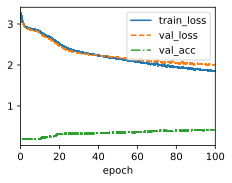

In [8]:
#Train model
#Get data from d2l

# batch_size = 1024
# steps = 32
# num_hiddens = 32
# num_inputs = 16

# data = d2l.TimeMachine(batch_size = batch_size, num_steps = steps)
# d = len(data.vocab)
# print(f'd={d}')

# rnn = RNN(num_inputs = len(data.vocab), num_hiddens=num_hiddens)
# model = RNNLanguageModel(rnn, vocab_size=len(data.vocab), lr = 1)
# trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus = 1)
# trainer.fit(model, data)

# print(torch.device('cuda'))
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLanguageModel(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)



In [ ]:
#Concise implementation of RNN 

class RNNTorch(d2l.Module):
  def __init__(self, num_inputs, num_hiddens):
    super().__init__()
    self.save_hyperparameters()
    self.rnn = nn.RNN(num_inputs, num_hiddens)
  
  def forward(self, inputs, H = None):
    return self.rnn(inputs, H)

class RNNLMTorch(d2l.RNNLMScratch):
  def init_params(self):
    self.linear = nn.LazyLinear(self.vocab_size)

  def ouptut_layer(self, hiddens):
    return self.linear(hiddens).swapaxes(0,1)

rnn = RNNTorch(num_inputs = d, num_hiddens = h)
model = RNNLMTorch(rnn, vocab_size = d, lr = 0.1)
model.predict('it has', 20, data.vocab)
  
